<a href="https://colab.research.google.com/github/Hideyuki-Machida/ML_demos/blob/main/%E9%A1%9E%E4%BC%BC%E7%94%BB%E5%83%8F%E6%A4%9C%E7%B4%A2_ResNet_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 類似画像検索 - ResNet-50

In [1]:
!nvidia-smi

Tue Jul 25 08:22:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install


In [2]:
!pip install qdrant-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
 

## Tiny ImageNet データセットを使用して Qdrant DB を作成

### Tiny ImageNet データセットをダウンロード

https://paperswithcode.com/dataset/tiny-imagenet

In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip


--2023-07-25 08:22:22--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  16.1MB/s    in 18s     

2023-07-25 08:22:41 (12.9 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



### Tiny ImageNet データセットの確認

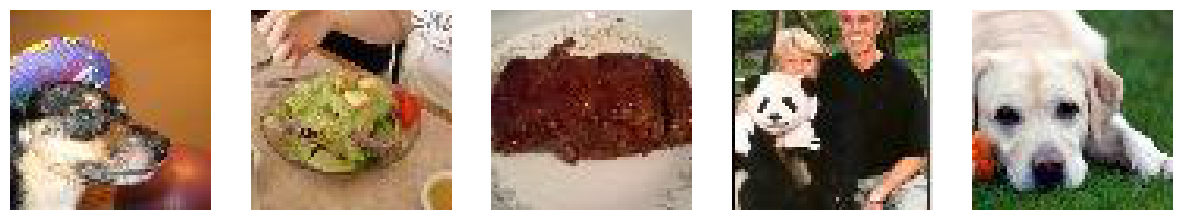

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 'tiny-imagenet-200/val/images'にある最初の5つの画像を表示
val_dir = 'tiny-imagenet-200/val/images'
image_files = os.listdir(val_dir)[:5]

fig, axs = plt.subplots(1, 5, figsize=(15, 15))

for i, image_file in enumerate(image_files):
    img = Image.open(os.path.join(val_dir, image_file))
    axs[i].imshow(img)
    axs[i].axis('off')

plt.show()


### ResNet-50モデルを使用して、ベクトルを作成

In [5]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import torch
from torchvision import models, transforms

#from qdrant_client.http import models
from qdrant_client.http.models import PointStruct

# Pretrained ResNet-50モデルをロードし、最後の全結合層を取り除く
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

# ImageNetの正規化パラメータ
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# 画像の前処理
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 normalize])

# Tiny ImageNetのvalディレクトリ内の画像をエンコード
val_dir = 'tiny-imagenet-200/val/images'
image_files = os.listdir(val_dir)

print("画像数: ", len(image_files))
points = []

for i, image_file in tqdm(enumerate(image_files)):
    img = Image.open(os.path.join(val_dir, image_file))

    try:
        img_t = preprocess(img)
        batch_t = torch.unsqueeze(img_t, 0)

        with torch.no_grad():
            out = model(batch_t)

        # Qdrant Pointを作成
        vector = out.numpy().flatten()
        payload = dict(file_name=image_file)
        point = PointStruct(id=i, vector=vector.tolist(), payload=payload)

        points.append(point)
    except:
        continue


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


画像数:  10000


10000it [16:16, 10.24it/s]


### Qdrantクライアントの設定・ベクトルを追加

In [6]:
from qdrant_client import QdrantClient
from qdrant_client import models

# Qdrantクライアントの設定
client = QdrantClient(path="./db")

client.recreate_collection(
    collection_name="tiny_imagenet",
    vectors_config=models.VectorParams(
        size=len(points[0].vector), distance=models.Distance.COSINE
    ),
    on_disk_payload=True,
)

# Qdrantにベクトルを追加
operation_info = client.upsert(
    collection_name="tiny_imagenet",
    points=points
)


## Qdrantを使用して、類似画像を検索。

----------------------------------------------
■ 検索元画像


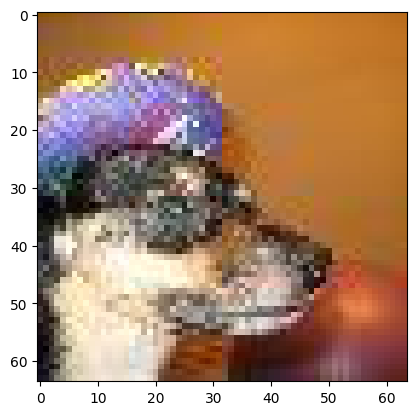

■ 検索結果スコア
* 1.0000001
* 0.837764
* 0.8213699
* 0.81320536
* 0.81175935
■ 検索結果画像


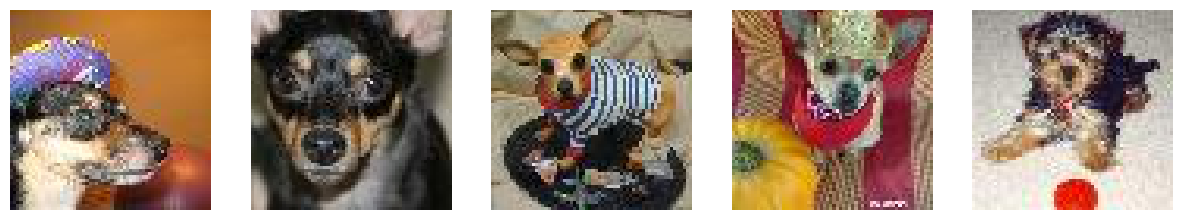

----------------------------------------------
■ 検索元画像


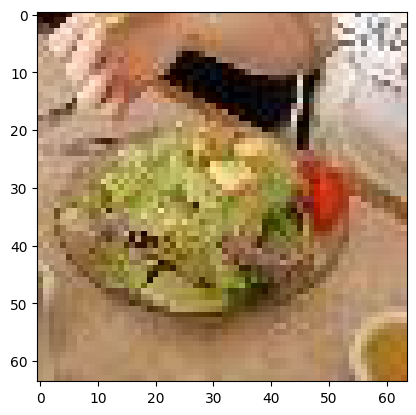

■ 検索結果スコア
* 1.0000001
* 0.8309962
* 0.8281516
* 0.8274681
* 0.8237254
■ 検索結果画像


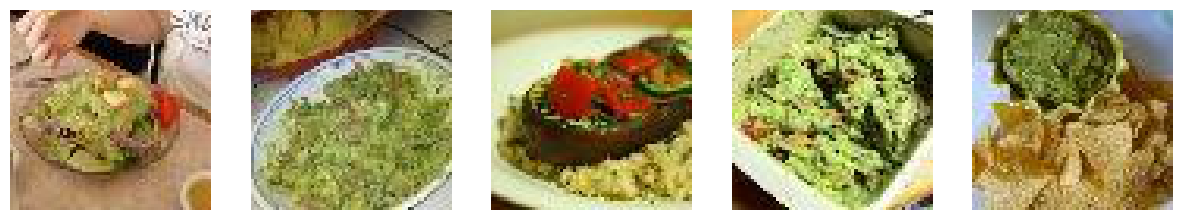

----------------------------------------------
■ 検索元画像


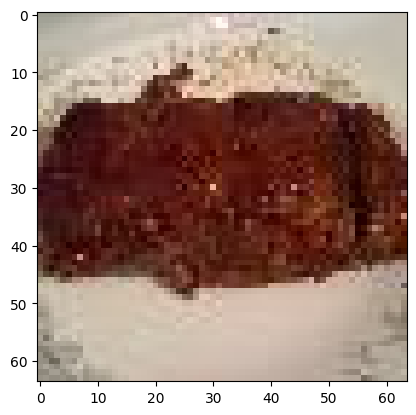

■ 検索結果スコア
* 1.0000001
* 0.85830796
* 0.8574828
* 0.8553926
* 0.8456894
■ 検索結果画像


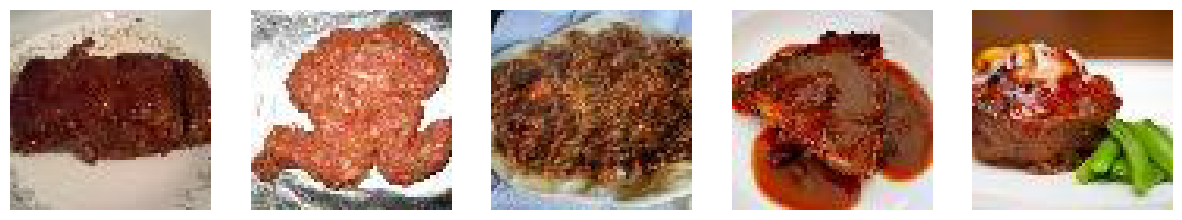

----------------------------------------------
■ 検索元画像


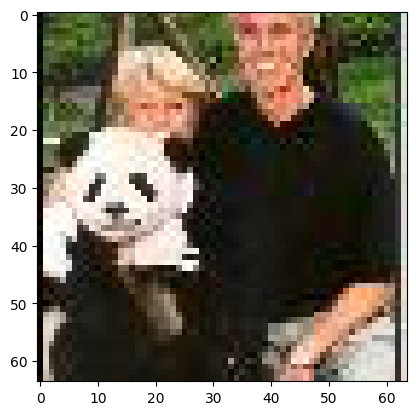

■ 検索結果スコア
* 1.0
* 0.85009944
* 0.8465735
* 0.84423906
* 0.8421961
■ 検索結果画像


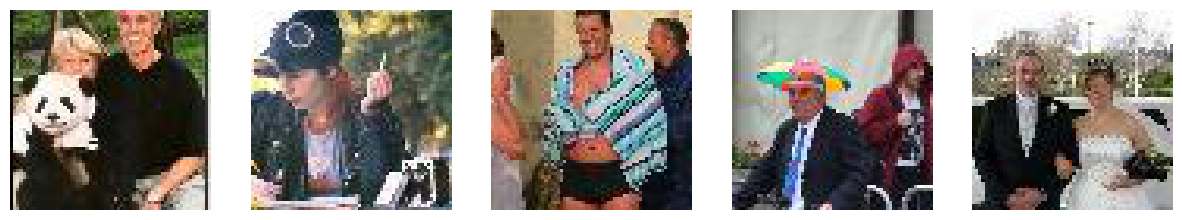

----------------------------------------------
■ 検索元画像


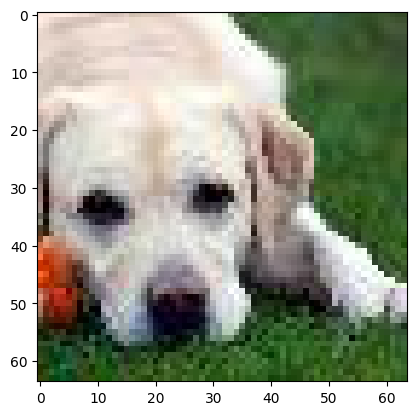

■ 検索結果スコア
* 1.0
* 0.8785783
* 0.8773341
* 0.8558586
* 0.85205185
■ 検索結果画像


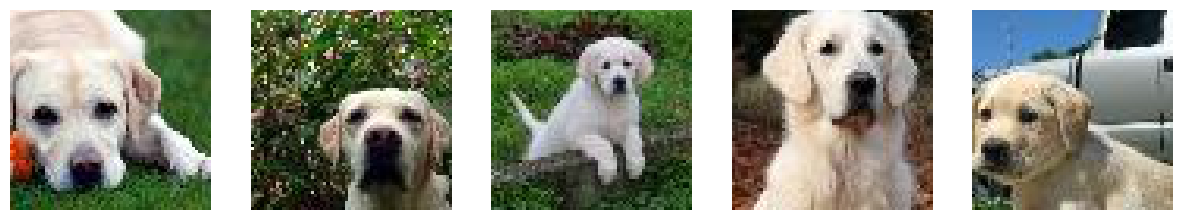

----------------------------------------------
■ 検索元画像


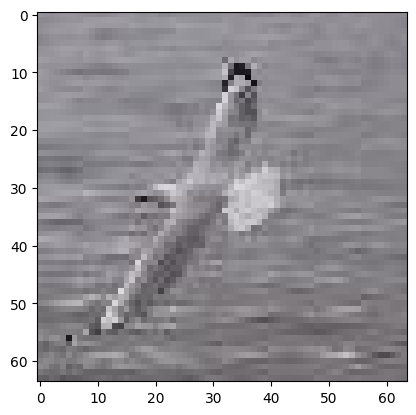

■ 検索結果スコア
* 1.0
* 0.8681176
* 0.8385267
* 0.8353305
* 0.83172715
■ 検索結果画像


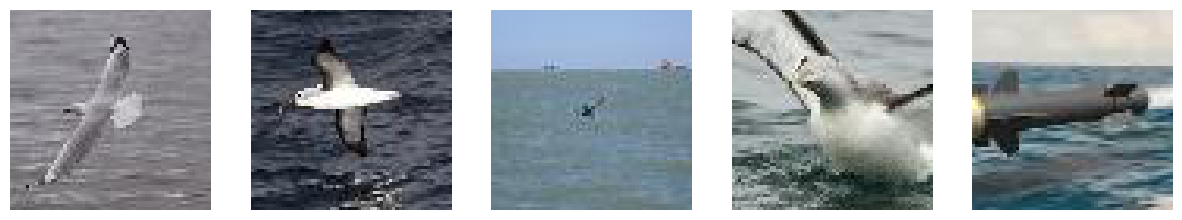

----------------------------------------------
■ 検索元画像


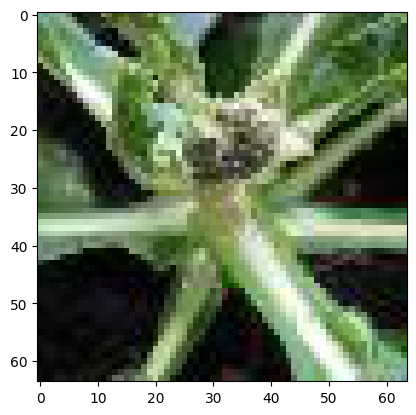

■ 検索結果スコア
* 1.0000002
* 0.85767233
* 0.8475939
* 0.84372306
* 0.83449703
■ 検索結果画像


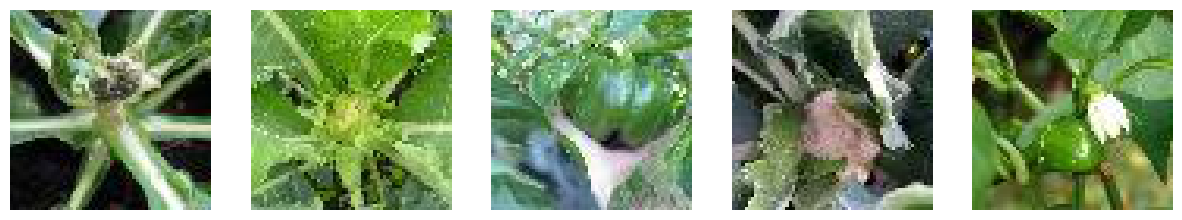

----------------------------------------------
■ 検索元画像


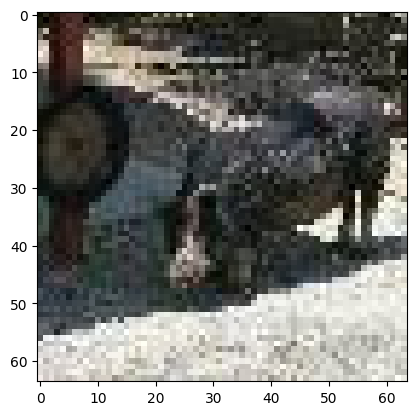

■ 検索結果スコア
* 1.0
* 0.8507563
* 0.8429667
* 0.841801
* 0.84112775
■ 検索結果画像


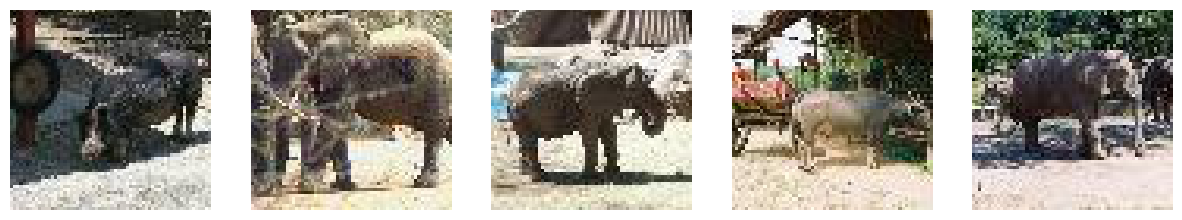

----------------------------------------------
■ 検索元画像


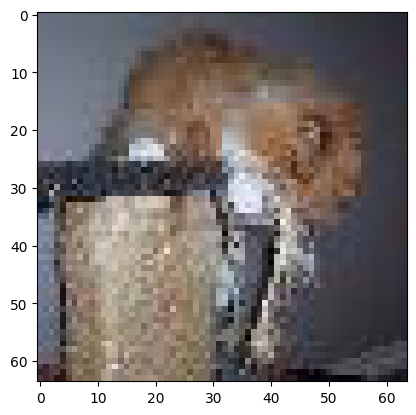

■ 検索結果スコア
* 0.99999994
* 0.81493425
* 0.8137522
* 0.81138504
* 0.80394524
■ 検索結果画像


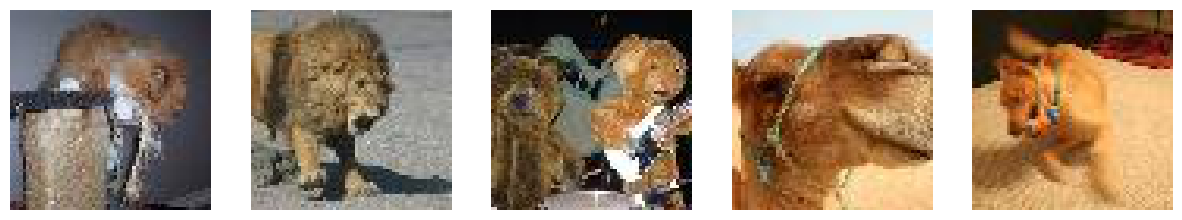

----------------------------------------------
■ 検索元画像


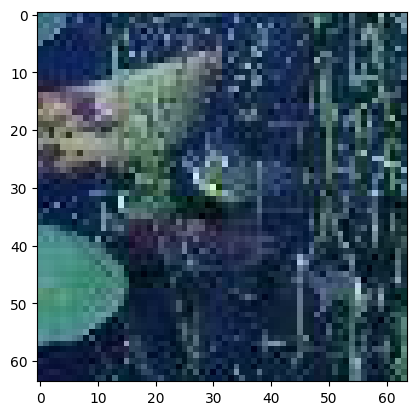

■ 検索結果スコア
* 0.9999998
* 0.79889286
* 0.7982239
* 0.7929549
* 0.7850862
■ 検索結果画像


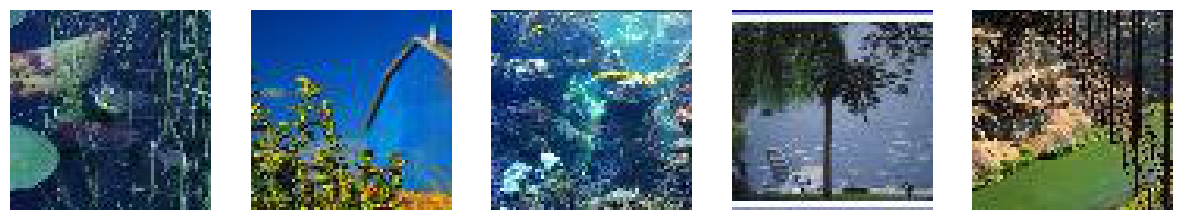

----------------------------------------------
■ 検索元画像


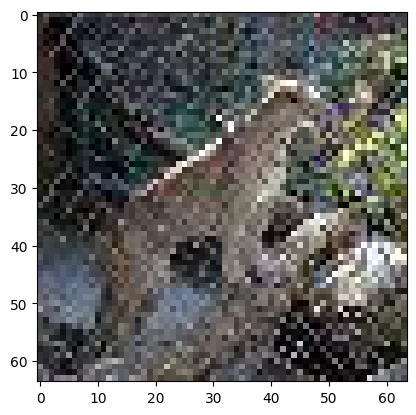

■ 検索結果スコア
* 1.0
* 0.84748125
* 0.8381969
* 0.82969373
* 0.82955
■ 検索結果画像


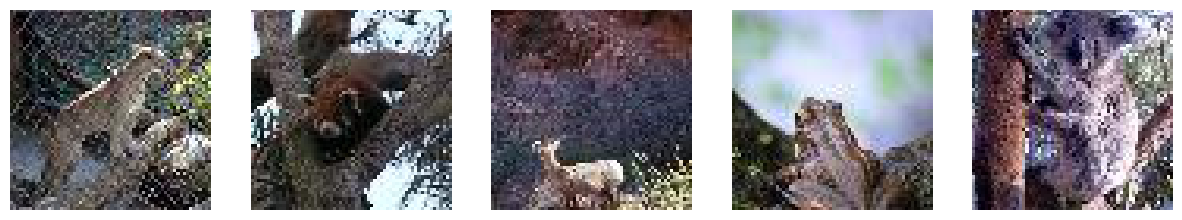

----------------------------------------------
■ 検索元画像


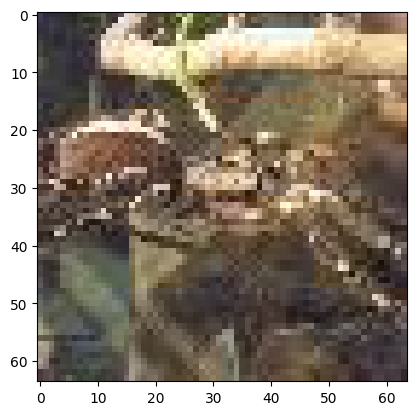

■ 検索結果スコア
* 1.0
* 0.83598864
* 0.8301274
* 0.8293499
* 0.8286849
■ 検索結果画像


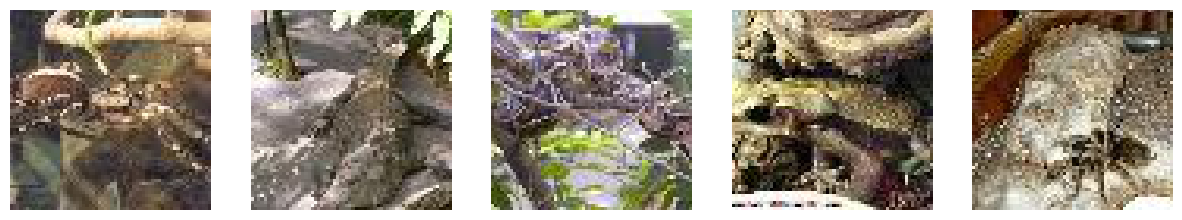

----------------------------------------------
■ 検索元画像


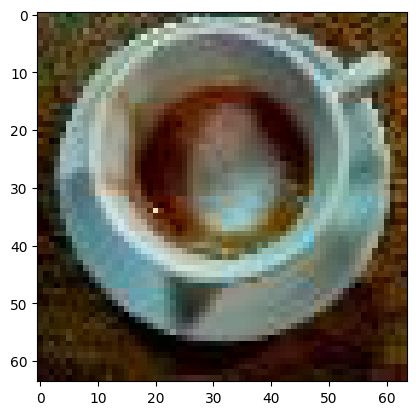

■ 検索結果スコア
* 1.0
* 0.9012535
* 0.8975355
* 0.88483924
* 0.880762
■ 検索結果画像


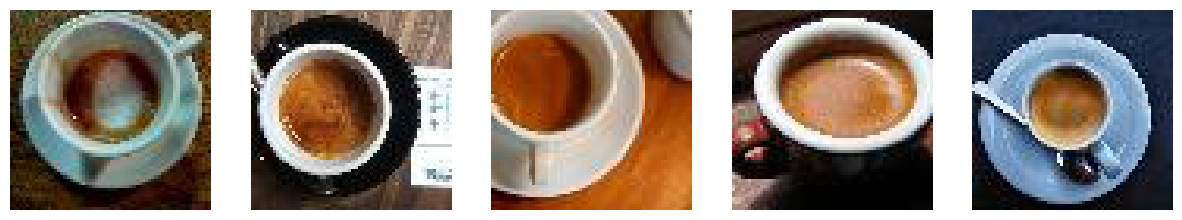

----------------------------------------------
■ 検索元画像


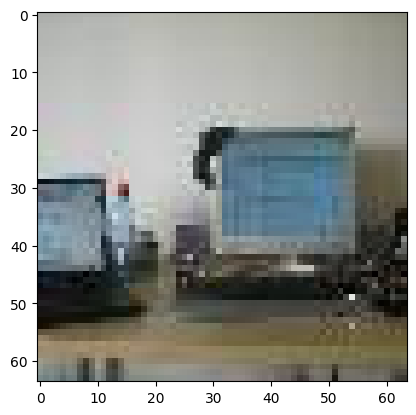

■ 検索結果スコア
* 1.0
* 0.87335116
* 0.8545743
* 0.8402525
* 0.83651567
■ 検索結果画像


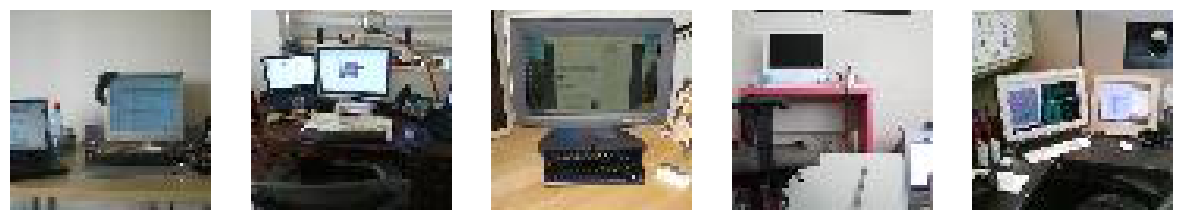

----------------------------------------------
■ 検索元画像


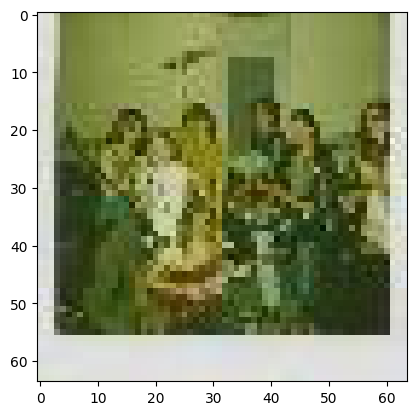

■ 検索結果スコア
* 1.0
* 0.85029167
* 0.8208653
* 0.8110453
* 0.80865836
■ 検索結果画像


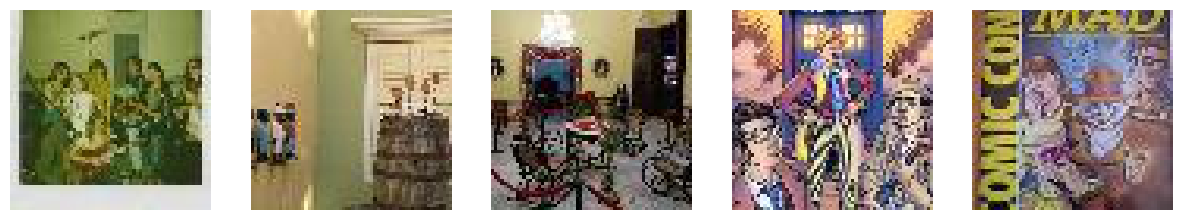

----------------------------------------------
■ 検索元画像


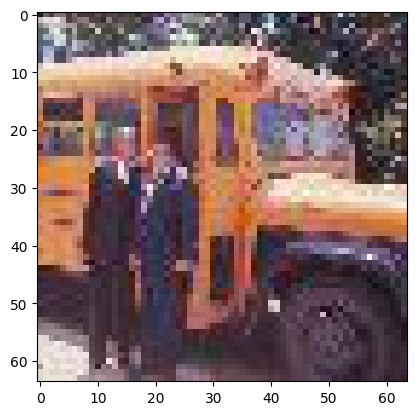

■ 検索結果スコア
* 0.9999999
* 0.8784152
* 0.87065554
* 0.86965656
* 0.8467945
■ 検索結果画像


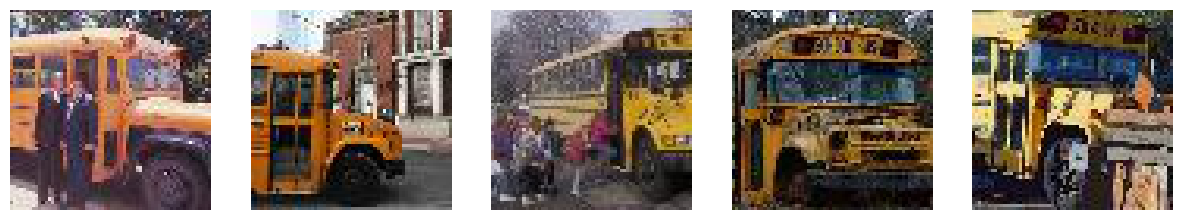

----------------------------------------------
■ 検索元画像


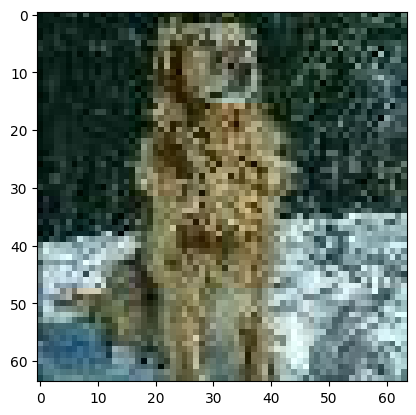

■ 検索結果スコア
* 0.99999994
* 0.8352519
* 0.8264526
* 0.8234153
* 0.82196724
■ 検索結果画像


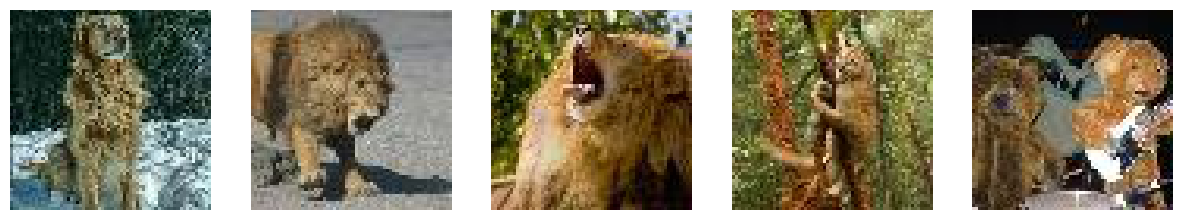

----------------------------------------------
■ 検索元画像


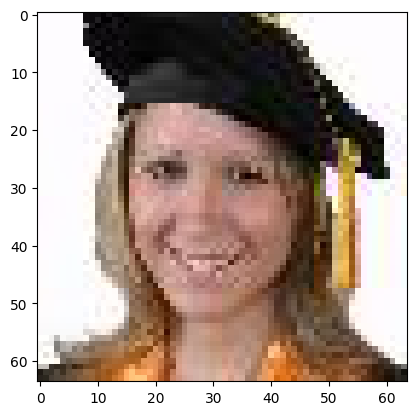

■ 検索結果スコア
* 0.99999976
* 0.88228106
* 0.87075245
* 0.85529137
* 0.8416257
■ 検索結果画像


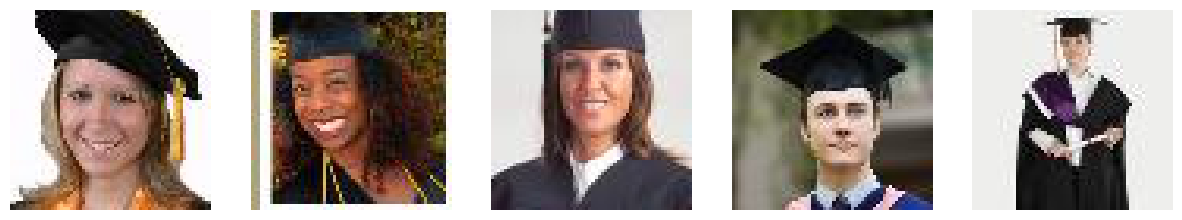

----------------------------------------------
■ 検索元画像


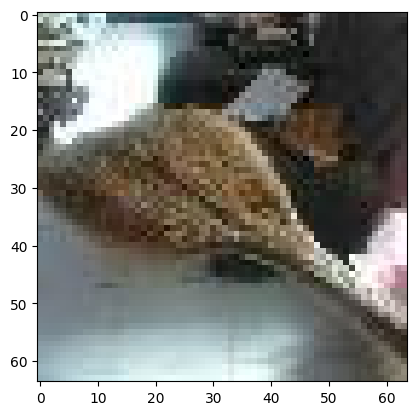

■ 検索結果スコア
* 0.99999994
* 0.79828596
* 0.7969887
* 0.7906704
* 0.7878928
■ 検索結果画像


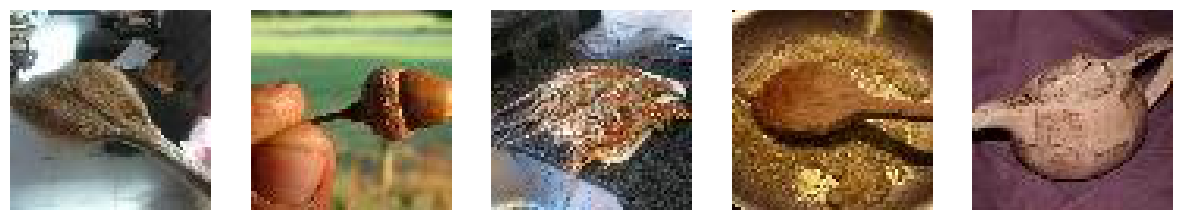

----------------------------------------------
■ 検索元画像


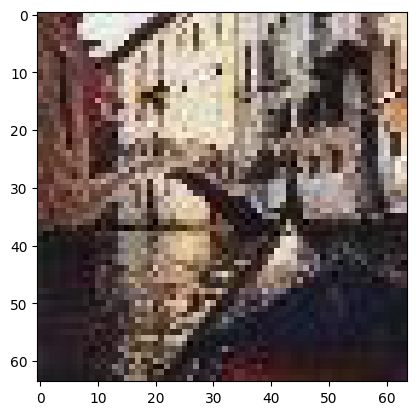

■ 検索結果スコア
* 0.9999999
* 0.8454298
* 0.8432322
* 0.8392403
* 0.83694005
■ 検索結果画像


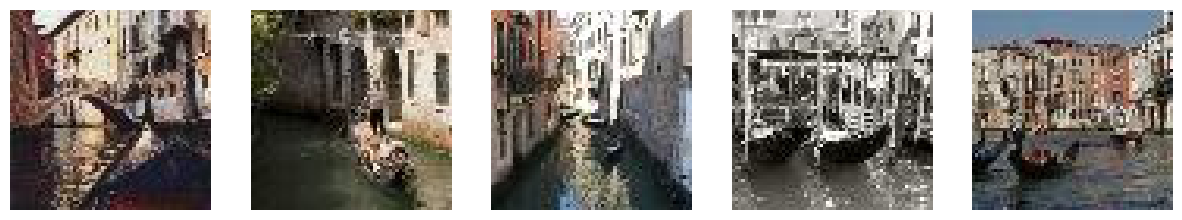

In [7]:
import matplotlib.pyplot as plt


def search(index):
    print("----------------------------------------------")

    # 検索の基準となる画像を準備
    base_image_file = image_files[index]
    base_img = Image.open(os.path.join(val_dir, base_image_file))

    print("■", "検索元画像")

    # 基準となる画像を表示
    plt.imshow(base_img)
    plt.show()

    # 基準となる画像をベクトルに変換
    base_img_t = preprocess(base_img)
    base_batch_t = torch.unsqueeze(base_img_t, 0)

    with torch.no_grad():
        base_out = model(base_batch_t)

    base_vector = base_out.numpy().flatten()

    # Qdrantに問い合わせて、最も類似した画像を検索
    response = client.search(
        collection_name="tiny_imagenet",
        query_vector=base_vector,
        limit=5,
    )

    print("■", "検索結果スコア")

    fig, axs = plt.subplots(1, 5, figsize=(15, 15))

    # 検索結果を表示
    for i, point in enumerate(response):
        print("*", point.score)
        img_file = os.path.join(val_dir, point.payload["file_name"])
        img = Image.open(img_file)
        axs[i].imshow(img)
        axs[i].axis('off')

    print("■", "検索結果画像")

    plt.show()

search(0)
search(1)
search(2)
search(3)
search(4)
search(5)
search(6)
search(7)
search(8)
search(9)
search(10)
search(11)
search(12)
search(13)
search(14)
search(15)
search(16)
search(17)
search(18)
search(19)